## Multi-label Classification

### Installing/Importing Libararies and setting enviornment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

In [4]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/6342_NLP_COURSE'

else:
    sys.path.append('/content/drive/MyDrive/6342_NLP_COURSE/model')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.1 MB/s eta 0:00:

In [5]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

In [6]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / 'datasets'
# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = base_folder / 'model'

In [7]:
model_folder.mkdir(exist_ok=True, parents = True)

In [8]:
model_folder

PosixPath('/content/drive/MyDrive/6342_NLP_COURSE/model')

### Load Data

In [9]:
import pandas as pd
train_path = data_folder/'train.csv'
test_path = data_folder/'test.csv'


In [10]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [11]:
# Printing shape of dataframe
train_df.shape

(7724, 13)

In [12]:
train_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [13]:
test_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [14]:
train_df.drop('ID', axis =1)



,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,1,0,1,0,0,0,0,0,0,0,0
7720,Excited to watch #stateoforigin tonight! Come ...,0,0,0,0,1,0,1,0,0,0,0
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...",1,0,1,0,0,0,0,0,1,0,0
7722,#ThingsIveLearned The wise #shepherd never tru...,0,0,0,0,0,0,0,0,0,0,0


## Cleaning the data

In [15]:
import re

In [16]:

def clean_text(text):
    text = re.sub('@[^\s]+','', text)
    text = re.sub(r"http\S+", "", text)
    text = ' '.join(re.findall(r'\w+', text))
    text = re.sub(r'\s+[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

train_df['Tweet'] = train_df['Tweet'].apply(clean_text)
test_df['Tweet'] = test_df['Tweet'].apply(clean_text)


In [17]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,Worry isdown payment onproblem you may never h...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,it also helps that the majority of NFL coachin...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate itokay that we canspell because we...,1,0,1,0,0,0,0,0,0,0,0


In [18]:
train_features = train_df['Tweet'].tolist()
train_labels = train_df.iloc[:, 2:].values.tolist()

In [19]:
X_test = test_df['Tweet'].tolist()
y_test = test_df.iloc[:, 2:].values.tolist()

###Data Preprocessing

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_features, train_labels,test_size = 0.3,random_state =42,shuffle = True)


In [21]:
type(X_train)

list

In [22]:
type(y_valid)

list

### Create Huggingface Dataset

In [23]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_valid,
    'labels': y_valid
})

testset = Dataset.from_dict({
    'texts': X_test,
    'labels': y_test
})

In [24]:
trainset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 5406
})

In [25]:
validset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 2318
})

In [26]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [27]:
trainset[1]

{'texts': 'Despite my sharingNeillarticle what saddens me about the Gazza case is there seems to be more fury about the sentence than the remark',
 'labels': [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]}

### Create Custom Model and Model Config Class

In [28]:
class CustomConfig(PretrainedConfig):
  def __init__(self, vocab_size=0, embedding_dim=0, hidden_dim1=0, hidden_dim2=0, num_labels=11, **kwargs):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.hidden_dim1 = hidden_dim1
      self.hidden_dim2 = hidden_dim2
      self.num_labels = num_labels

In [29]:
class CustomMLP(PreTrainedModel):
    config_class = CustomConfig

    def __init__(self, config):
        super().__init__(config)

        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim)
        self.layers = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim1),
            nn.BatchNorm1d(num_features=config.hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim1, config.hidden_dim2),
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim2, config.num_labels)
        )

    def forward(self, input_ids, offsets, labels=None):
        embed_out = self.embedding_bag(input_ids, offsets)
        logits = self.layers(embed_out)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

### Train Model

### Collate Function

In [30]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (Dataset): A Hugging Face Dataset object. The dataset should
                           have a key 'texts' that contains the text data.
        min_freq (int): The minimum frequency for a token to be included in
                        the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object containing tokens from the
                               dataset that meet or exceed the specified
                               minimum frequency. It also includes a special
                               '<unk>' token for unknown words.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    # Iterating through texts in the dataset
    for text in dataset['texts']:  ###### Change from previous function ####
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [31]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(text, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(text).split()]

In [32]:
def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' and 'texts'. 'labels' are the sentiment labels, and
                              'texts' are the corresponding texts.
        my_vocab (torchtext.vocab.Vocab): A vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': a tensor containing concatenated indices of the texts.
              - 'offsets': a tensor representing the starting index of each text in 'input_ids'.
              - 'labels': a tensor of the labels for each text in the batch.

    The function transforms each text into a list of indices based on the provided vocabulary.
    It also converts the labels into a tensor. The 'offsets' are computed to keep track of the
    start of each text within the 'input_ids' tensor, which is a flattened representation of all text indices.
    """

    # Get labels and texts from batch dict samples
    labels = [sample['labels'] for sample in batch]
    texts = [sample['texts'] for sample in batch]

    # Convert the list of labels into a tensor of dtype float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return {
        'input_ids': input_ids,
        'offsets': offsets,
        'labels': labels
    }

In [33]:
tweet_vocab = get_vocab(trainset, min_freq=2)
collate_fn = partial(collate_batch, my_vocab=tweet_vocab)

### Instantiate Model

In [34]:
my_config = CustomConfig(vocab_size=len(tweet_vocab),
                         embedding_dim=300,
                         hidden_dim1=200,
                         hidden_dim2=100,
                         num_labels=11)

In [35]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "transformers_version": "4.39.3",
  "vocab_size": 5907
}

In [36]:
my_config.id2label = {0: 'anger', 1: 'anticipation', 2: 'disgust', 3:'fear', 4: 'joy', 5: 'love', 6:'optimism', 7:'pessimism', 8:'sadness', 9:'surprise', 10:'trust'}

In [37]:
# Generating id_to_label by reversing the key-value pairs in label_to_id
my_config.label2id = {v: k for k, v in my_config.id2label .items()}

In [38]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "transformers_version": "4.39.3",
  "vocab_size": 5907
}

In [39]:
model = CustomMLP(config=my_config)

In [40]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(5907, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=11, bias=True)
  )
)

### compute_metrics function

In [41]:
def compute_metrics(eval_pred):
    combined_metrics = evaluate.combine([evaluate.load("accuracy"),
                                        evaluate.load("f1", average="macro")])

    logits, labels = eval_pred
    predictions = (logits>0.5).astype(int).reshape(-1)
    evaluations = combined_metrics.compute(
        predictions=predictions, references = labels.astype(int).reshape(-1),
    )
    return evaluations

### Training Arguments

In [42]:
# Configure training parameters
training_args = TrainingArguments(

    # Training-specific configurations
    num_train_epochs=30,
    per_device_train_batch_size=128, # Number of samples per training batch
    per_device_eval_batch_size=128, # Number of samples per validation batch
    weight_decay=0.5, # weight decay (L2 regularization)
    learning_rate=0.0005, # learning arte
    optim='adamw_torch', # optimizer
    remove_unused_columns=False, # flag to retain unused columns

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 50 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='tweet_hf_trainer',  # Experiment name for Weights & Biases
)

### Initialize Trainer

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset = validset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Setup WandB

In [44]:
!wandb login 613ff39916b4483921c44a083197386faebfd85b


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
# specify the project name where the experiment will be logged
%env WANDB_PROJECT = nlp_course_spring_2024-sentiment-analysis-hf-trainer

env: WANDB_PROJECT=nlp_course_spring_2024-sentiment-analysis-hf-trainer


### Training and Validation

In [46]:
trainer.train()

wandb: Currently logged in as: nxe210013 (nagalakshmi). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
100,0.583800,0.525626,0.786571,0.004391
200,0.480100,0.480110,0.787277,0.011301
300,0.451300,0.461355,0.791670,0.067088
400,0.425500,0.442624,0.802416,0.193145
500,0.402500,0.432383,0.808103,0.261880
600,0.383500,0.424141,0.811907,0.309729
700,0.367100,0.420194,0.815280,0.361962
800,0.355300,0.416490,0.817633,0.374496
900,0.344000,0.416111,0.819123,0.394909
1000,0.339300,0.414010,0.820104,0.402812


TrainOutput(global_step=1290, training_loss=0.39445241292317706, metrics={'train_runtime': 122.8496, 'train_samples_per_second': 1320.15, 'train_steps_per_second': 10.501, 'total_flos': 24794210594160.0, 'train_loss': 0.39445241292317706, 'epoch': 30.0})

In [47]:
trainer.evaluate()

{'eval_loss': 0.41325318813323975,
 'eval_accuracy': 0.82053494391717,
 'eval_f1': 0.41015725702500644,
 'eval_runtime': 6.7231,
 'eval_samples_per_second': 344.779,
 'eval_steps_per_second': 2.826,
 'epoch': 30.0}

In [48]:
valid_output = trainer.predict(validset)

In [49]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [50]:
valid_output.predictions

array([[-0.84122586, -1.0111204 , -0.80053675, ..., -1.1059527 ,
        -1.8388253 , -1.8574413 ],
       [-3.6426454 , -1.2452769 , -3.6838512 , ..., -2.7510722 ,
        -2.506678  , -1.8427474 ],
       [-0.82907677, -1.3069501 , -0.8159121 , ..., -1.2128291 ,
        -2.4301863 , -2.2177966 ],
       ...,
       [-1.7551295 , -1.1189958 , -2.037755  , ..., -2.2096174 ,
        -2.361281  , -2.1747398 ],
       [ 0.26107258, -2.1355777 ,  0.37318346, ...,  0.21714598,
        -2.3908994 , -3.1313028 ],
       [-2.2359893 , -0.77506846, -2.3692641 , ..., -1.6510063 ,
        -2.3123648 , -1.8432537 ]], dtype=float32)

In [51]:
valid_preds = (valid_output.predictions>0).astype(int)
valid_labels = np.array(valid_output.label_ids).astype(int)

In [52]:
 # Flatten the arrays to 1D for calculating confusion matrix
valid_labels_1 = valid_labels.argmax(axis=1)  # Reshape to (2318,) for comparison
valid_preds_1 = valid_preds.argmax(axis=1)  # Reshape to (2318,) for comparison

In [53]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels_1, valid_preds_1, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


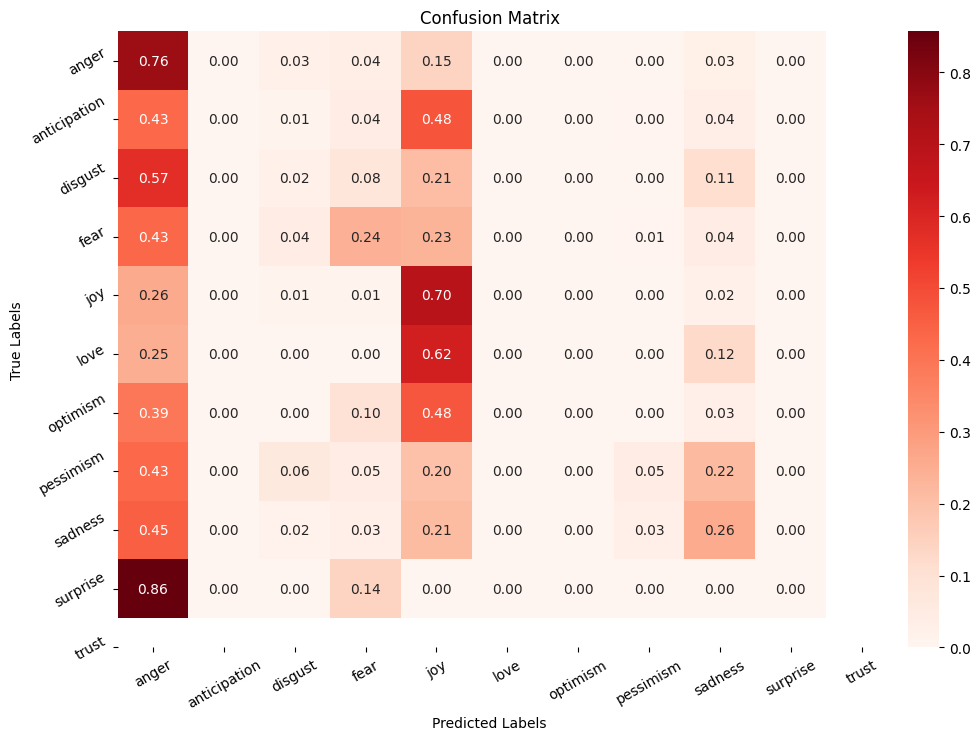

In [54]:
plot_confusion_matrix(valid_labels, valid_preds, class_labels=list(my_config.id2label.values()))

In [55]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 1200.


In [56]:
wandb.finish()

eval/accuracy,▁▁▂▄▅▆▇▇█████
eval/f1,▁▁▂▄▅▆▇▇█████
eval/loss,█▅▄▃▂▂▁▁▁▁▁▁▁
eval/runtime,▇▃▂▂▁▃▄▄█▂▁▄▃
eval/samples_per_second,▂▆▇▆█▅▄▅▁▇█▄▆
eval/steps_per_second,▂▆▇▆█▅▄▅▁▇█▄▆
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/grad_norm,▂▁▂▃▅▅▆▆▇█▆█
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▅▄▄▃▃▂▂▁▁▁▁


## Load Model from checkpoint

In [57]:
# Define the path to the best model checkpoint
# 'model_checkpoint' variable is constructed using the model folder path and the checkpoint step
# This step is identified as having the best model performance during training
model_checkpoint = model_folder/f'checkpoint-{best_model_checkpoint_step}'

In [58]:
# Instantiate the CustomMLP model with predefined configurations
# 'my_config' is an instance of the CustomConfig class, containing specific model settings like
# vocabulary size, embedding dimensions, etc.
model = CustomMLP(my_config)

In [59]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(5907, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=11, bias=True)
  )
)

## Inference

In [60]:
sample_X =  X_test

In [61]:
sample_X

['Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences eschews the normally sober tone of scientific papers and calls the massive loss of wildlifebiological annihilation',
 'I blew that opportunity __ mad',
 'This time in 2 weekswill be 30',
 'Deppression is real Partnersdepressed people truly dont understand the depth in which they affect us Add in anxiety amp makes it worse',
 'Interesting choice of words Are you confirming that governments fund terrorism Bit of an open door but still',
 'CNN should for sure',
 'Distance yourself once stretched by your friends impose serious loveyou notseriously',
 'Be happy Be confident Be kindn KissablesLoveSMShopmag nAllOutDenimFor KISSMARC',
 'My visit to hospital for care triggered trauma from accident 20 yrs ago and image of my dead brother in it Feeling symptoms of depression',
 'Thanks to Dollis Hillrelentless and tenacious PC Leach and colleagues',
 'I ve retweeted and followed good luck',
 'Welcom

In [62]:
device = 'cpu'
# Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
list_of_list_of_indices = [tokenizer(text, tweet_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

In [63]:
indices

tensor([   0, 1274, 2213,  ..., 5313,   38, 1807])

In [64]:
offsets

tensor([    0,    14,    33,  ..., 44321, 44328, 44342])

In [65]:
# move model to appropriate device
model.to(device)

# put model in evaluation mode
model.eval()

# get outputs (logits) from model
outputs = model(indices, offsets)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0485, -0.0654, -0.0754,  ..., -0.0701, -0.0968, -0.0627],
        [ 0.0769, -0.0511, -0.0910,  ..., -0.0948, -0.1199, -0.0319],
        [ 0.0914, -0.0546, -0.1356,  ..., -0.1200, -0.1075, -0.0447],
        ...,
        [ 0.0740, -0.0284, -0.1057,  ..., -0.1288, -0.1040, -0.0377],
        [ 0.0720, -0.0918, -0.0869,  ..., -0.0642, -0.0519, -0.0947],
        [ 0.0722, -0.0870, -0.1075,  ..., -0.0826, -0.1007, -0.0638]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [66]:
outputs.logits

tensor([[ 0.0485, -0.0654, -0.0754,  ..., -0.0701, -0.0968, -0.0627],
        [ 0.0769, -0.0511, -0.0910,  ..., -0.0948, -0.1199, -0.0319],
        [ 0.0914, -0.0546, -0.1356,  ..., -0.1200, -0.1075, -0.0447],
        ...,
        [ 0.0740, -0.0284, -0.1057,  ..., -0.1288, -0.1040, -0.0377],
        [ 0.0720, -0.0918, -0.0869,  ..., -0.0642, -0.0519, -0.0947],
        [ 0.0722, -0.0870, -0.1075,  ..., -0.0826, -0.1007, -0.0638]],
       grad_fn=<AddmmBackward0>)

In [67]:
# get predicted labels
probabilities = torch.sigmoid(outputs.logits)
threshold = 0.5
predicted_labels = (probabilities >= threshold).int()
no_labels = predicted_labels.sum(1) == 0
predicted_labels[no_labels, torch.max(probabilities[no_labels], dim=1).indices] = 1

In [68]:
print(predicted_labels)

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [69]:
binary_predictions = predicted_labels
predicted_label_names = []
for prediction in binary_predictions:
    labels = [model.config.id2label[i] for i, label in enumerate(prediction) if label == 1]
    predicted_label_names.append(labels)

In [70]:
tweets_data = pd.DataFrame(sample_X, columns=['tweets'])
tweets_data['predicted_label'] = predicted_label_names

In [71]:
tweets_data

,tweets,predicted_label
0,Dont worry Indian army is on its ways to dispa...,"[anger, joy, love, pessimism]"
1,Academy of Sciences eschews the normally sober...,"[anger, love, optimism, pessimism]"
2,I blew that opportunity __ mad,"[anger, love, optimism, pessimism]"
3,This time in 2 weekswill be 30,"[anger, joy, love, optimism, pessimism]"
4,Deppression is real Partnersdepressed people t...,"[anger, love, optimism, pessimism]"
...,...,...
3254,shaft abrasions from panties merely shifted to...,"[anger, love, optimism, pessimism]"
3255,heard of Remothered Indie horror game Writing ...,"[anger, love, pessimism]"
3256,All this fake outrageall need to stop,"[anger, love, pessimism]"
3257,Would be ever so grateful if you could record ...,"[anger, love, optimism, pessimism]"


In [72]:
test_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,Dont worry Indian army is on its ways to dispa...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,Academy of Sciences eschews the normally sober...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity __ mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weekswill be 30,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,Deppression is real Partnersdepressed people t...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3255,2018-00416,heard of Remothered Indie horror game Writing ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3256,2018-03717,All this fake outrageall need to stop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [73]:
my_config.id2label.values()

dict_values(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])

In [74]:
print(predicted_labels.shape)

torch.Size([3259, 11])


In [75]:
import pandas as pd
data_sub = pd.DataFrame(predicted_labels.numpy(), columns=my_config.id2label.values())
data_sub.insert(0, 'ID', test_df['ID'])
data_sub


,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,0,0,1,1,0,1,0,0,0
1,2018-03739,1,0,0,0,0,1,1,1,0,0,0
2,2018-00385,1,0,0,0,0,1,1,1,0,0,0
3,2018-03001,1,0,0,0,1,1,1,1,0,0,0
4,2018-01988,1,0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,0,0,0,1,1,1,0,0,0
3255,2018-00416,1,0,0,0,0,1,0,1,0,0,0
3256,2018-03717,1,0,0,0,0,1,0,1,0,0,0
3257,2018-03504,1,0,0,0,0,1,1,1,0,0,0


In [77]:
data_sub.to_csv(data_folder/'submission_Final.csv', index=False)